In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Add mavenn to the path
import sys
sys.path.insert(0, '../')

# Import mavenn
import mavenn

In [2]:
# Load dataset as a dataframe
data_df = mavenn.load_example_dataset('mpsa')

# Split into training and test data
ix = (data_df['set']!='test')
train_df = data_df[ix]
test_df = data_df[~ix]

# Extract x and y as np.arrays
x_train = train_df['x'].values
y_train = train_df['y'].values
x_test = test_df['x'].values
y_test = test_df['y'].values

In [3]:
# Define a model with:
# - a pairwise G-P map
# - a GE measurement process
# - a heteroskedastic SkewedT noise model
model = mavenn.Model(regression_type='GE',
                     L=len(x_train[0]),
                     gpmap_type='pairwise',
                     alphabet='rna',
                     ge_noise_model_type='SkewedT',
                     ge_nonlinearity_monotonic=True,
                     ge_heteroskedasticity_order=2)

# Set training data
model.set_data(x=x_train,
               y=y_train)

N = 24,405 observations set as training data.
Using 20.5% for validation.
Data shuffled.
Time to set data: 0.208 sec.


In [4]:
# Fit model to training data
start_time = time.time()
model.fit(epochs=30,
          learning_rate=0.005,
          early_stopping=False,
          try_tqdm=False)
training_time = time.time()-start_time

 
LSMR            Least-squares solution of  Ax = b

The matrix A has 19411 rows and 36 columns
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =       36

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  1.395e+02  4.731e+03   1.0e+00  2.4e-01
     1  6.42469e-05  1.267e+02  1.614e+03   9.1e-01  1.6e-01  8.0e+01  1.0e+00
     2  2.45106e-03  1.260e+02  1.301e+03   9.0e-01  7.5e-02  1.4e+02  1.2e+00
     3  2.68601e-03  1.251e+02  5.604e+01   9.0e-01  1.6e-03  2.8e+02  2.0e+00
     4  2.83832e-03  1.251e+02  3.525e+00   9.0e-01  9.8e-05  2.9e+02  2.5e+00
     5  2.86341e-03  1.251e+02  4.090e-01   9.0e-01  1.1e-05  3.0e+02  2.6e+00
     6  2.84800e-03  1.251e+02  1.388e-02   9.0e-01  3.7e-07  3.0e+02  2.6e+00
 
LSMR finished
The least-squares solution is good enough, given atol     
istop =       2    normr = 1.3e+02
    normA = 3.0e+02    normAr = 1.4e-02
itn   =   

I_var_test: 0.317 +- 0.024 bits
I_pred_test: 0.369 +- 0.012 bits


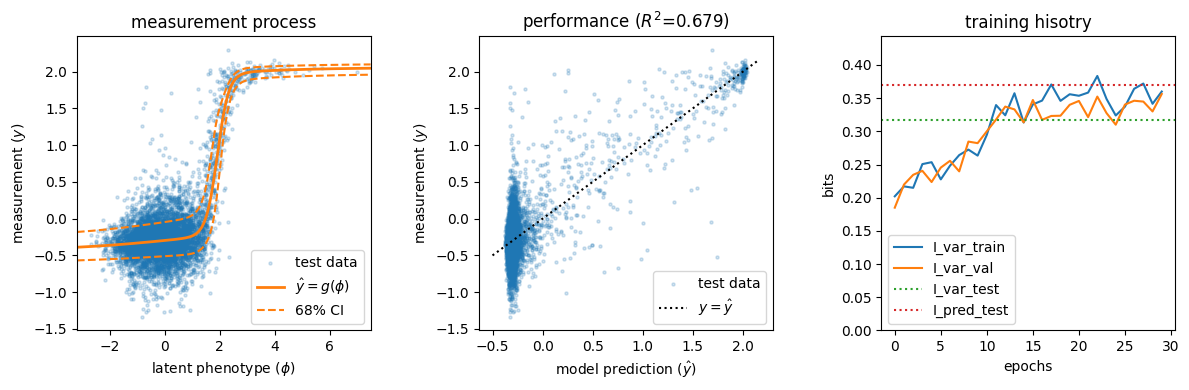

In [5]:
# Predict latent phentoype values (phi) on test data
phi_test = model.x_to_phi(x_test)

# Predict measurement values (yhat) on test data
yhat_test = model.x_to_yhat(x_test)

# Compute R^2 between yhat and y_test
Rsq = np.corrcoef(yhat_test.ravel(), y_test)[0, 1]**2

# Set phi lims and create grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 68% CI for each yhat
yqs_grid = model.yhat_to_yq(yhat_grid, q=[0.16, 0.84])

# Extract training loss and validation loss
loss_training = model.history['loss']
loss_validation = model.history['val_loss']

# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize=[12, 4])

# Left panel: illustrate measurement process (y vs. phi)
ax = axs[0]
ax.scatter(phi_test, y_test, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label=r'$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel(r'latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Center panel: illustrate model performance (y vs. yhat)
ax = axs[1]
ys = np.vstack([y_test])
ax.scatter(yhat_test, y_test, color='C0', s=5, alpha=.2, label='test data')
lims = ax.get_xlim()
ax.plot(lims, lims, linestyle=':', color='k', label=r'$y=\hat{y}$')
ax.set_xlabel(r'model prediction ($\hat{y}$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title(f'performance ($R^2$={Rsq:.3})')
ax.legend()

# Right panel: Plot model training history
ax = axs[2]
# Compute likelihood information
I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits')

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

# 25.01.21 I_var and val_I_var are no longer being tracked during model training
# Get training history
I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

# Plot training history as well as information values
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.axhline(I_var, color='C2', linestyle=':', label='I_var_test')
ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
ax.set_ylim([0, I_pred*1.2])

# Tighten bounds on figure
fig.tight_layout(w_pad=3)
#fig.savefig('mpsa_ge_training.png')
plt.show()
